## 1. Import Required Libraries

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Add src to path
sys.path.insert(0, str(Path('../src').resolve()))

from ppa_payoff import (
    ppa_payoff,
    ppa_payoff_aggregate,
    ppa_payoff_statistics
)

# Settings
sns.set_style("whitegrid")
sns.set_palette("husl")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

## 2. Load Processed Data - Spanish Market (MIBEL)

Data coverage: January 2015 - December 2025 (11 years) from Spain's MIBEL market.

In [2]:
# Load processed data
data_dir = Path('../data_processed')

df_solar = pd.read_csv(data_dir / 'ES_combined_hourly_solar.csv', index_col=0, parse_dates=True)
df_wind_onshore = pd.read_csv(data_dir / 'ES_combined_hourly_wind_onshore.csv', index_col=0, parse_dates=True)

print(f"Spanish Market Data (MIBEL)")
print(f"="*50)
print(f"Solar data: {len(df_solar):,} hourly records")
print(f"Wind Onshore data: {len(df_wind_onshore):,} hourly records")
print(f"\nPeriod: {df_solar.index.min()} to {df_solar.index.max()}")

# Calculate monthly periods for CVaR analysis
monthly_periods = len(pd.date_range(df_solar.index.min(), df_solar.index.max(), freq='ME'))
print(f"Monthly periods: {monthly_periods} months (~{int(monthly_periods * 0.05)} worst months for CVaR 5%)")

Spanish Market Data (MIBEL)
Solar data: 96,170 hourly records
Wind Onshore data: 96,170 hourly records

Period: 2015-01-01 00:00:00 to 2025-12-22 11:00:00
Monthly periods: 131 months (~6 worst months for CVaR 5%)


## 2.1 Monthly Aggregation

For CVaR optimisation and financing analysis, we aggregate to monthly level:
- **Risk Management**: Debt service and cash flows operate on monthly cycles
- **CVaR Calculation**: With 11 years of data, we have ~96 months, providing ~5 worst months for CVaR 5%
- **Statistical Robustness**: Monthly aggregation smooths hourly volatility while preserving risk structure

In [3]:
# Aggregate hourly data to monthly for risk analysis
# Sum generation (MWh per month)
df_solar_monthly = df_solar.resample('ME').sum()
df_wind_monthly = df_wind_onshore.resample('ME').sum()

# Calculate weighted average price (weighted by generation)
df_solar_monthly['price_eur_mwh'] = (
    (df_solar['price_eur_mwh'] * df_solar['generation_mwh_solar'])
    .resample('ME').sum() / df_solar_monthly['generation_mwh_solar']
)

df_wind_monthly['price_eur_mwh'] = (
    (df_wind_onshore['price_eur_mwh'] * df_wind_onshore['generation_mwh_wind_onshore'])
    .resample('ME').sum() / df_wind_monthly['generation_mwh_wind_onshore']
)

print(f"\nMonthly Aggregated Data:")
print(f"Solar: {len(df_solar_monthly)} months")
print(f"Wind: {len(df_wind_monthly)} months")
print(f"\nMean monthly generation:")
print(f"  Solar: {df_solar_monthly['generation_mwh_solar'].mean():,.0f} MWh/month")
print(f"  Wind: {df_wind_monthly['generation_mwh_wind_onshore'].mean():,.0f} MWh/month")


Monthly Aggregated Data:
Solar: 132 months
Wind: 132 months

Mean monthly generation:
  Solar: 9,119 MWh/month
  Wind: 12,057 MWh/month


## 3. PPA Payoff Structure Visualisation

This plot shows the fundamental structure of a collared PPA. The y-axis shows what the seller receives per MWh as a function of the market spot price (x-axis).

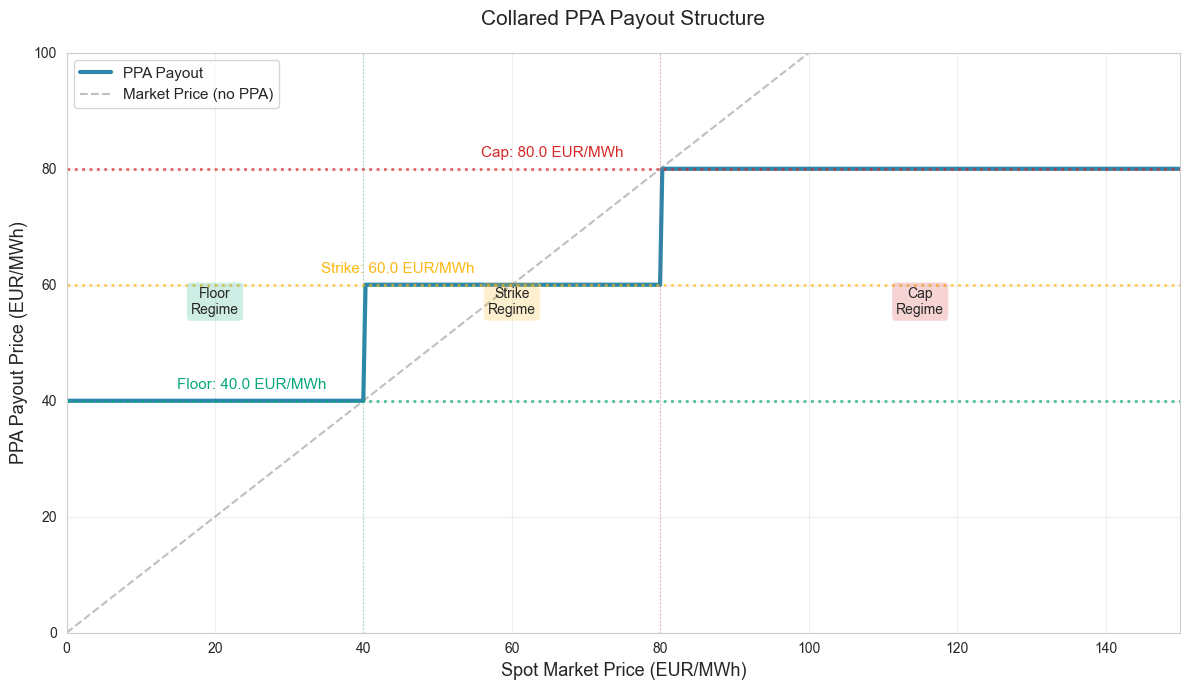


Key insights:
- When spot < 40.0 EUR/MWh: Seller protected at floor price
- When 40.0 ≤ spot < 80.0 EUR/MWh: Seller receives strike price
- When spot ≥ 80.0 EUR/MWh: Seller's upside capped


In [4]:
# Define example PPA parameters
floor = 40.0
strike = 60.0
cap = 80.0

# Create spot price range for visualisation
spot_prices = np.linspace(0, 150, 500)

# Calculate payout price for each spot price
payout_prices = np.where(spot_prices < floor, floor,
                         np.where(spot_prices < cap, strike, cap))

# Create plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot PPA payout structure
ax.plot(spot_prices, payout_prices, linewidth=3, color='#2E86AB', label='PPA Payout')

# Add reference line (market price = payout price)
ax.plot(spot_prices, spot_prices, linestyle='--', color='gray', alpha=0.5, label='Market Price (no PPA)')

# Mark floor, strike, and cap levels
ax.axhline(y=floor, color='#06A77D', linestyle=':', linewidth=2, alpha=0.7)
ax.axhline(y=strike, color='#FDB813', linestyle=':', linewidth=2, alpha=0.7)
ax.axhline(y=cap, color='#D62828', linestyle=':', linewidth=2, alpha=0.7)

# Mark vertical transitions
ax.axvline(x=floor, color='#06A77D', linestyle=':', linewidth=1, alpha=0.3)
ax.axvline(x=cap, color='#D62828', linestyle=':', linewidth=1, alpha=0.3)

# Add annotations
ax.text(floor - 5, floor + 2, f'Floor: {floor} EUR/MWh', 
        fontsize=11, ha='right', color='#06A77D')
ax.text(strike - 5, strike + 2, f'Strike: {strike} EUR/MWh', 
        fontsize=11, ha='right', color='#FDB813')
ax.text(cap - 5, cap + 2, f'Cap: {cap} EUR/MWh', 
        fontsize=11, ha='right', color='#D62828')

# Add regime labels
ax.text(floor/2, strike-5, 'Floor\nRegime', fontsize=10, ha='center', 
        bbox=dict(boxstyle='round', facecolor='#06A77D', alpha=0.2))
ax.text((floor+cap)/2, strike-5, 'Strike\nRegime', fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='#FDB813', alpha=0.2))
ax.text((cap+150)/2, strike-5, 'Cap\nRegime', fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='#D62828', alpha=0.2))

# Labels and formatting
ax.set_xlabel('Spot Market Price (EUR/MWh)', fontsize=13)
ax.set_ylabel('PPA Payout Price (EUR/MWh)', fontsize=13)
ax.set_title('Collared PPA Payout Structure', fontsize=15, pad=20)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 150)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\nKey insights:")
print(f"- When spot < {floor} EUR/MWh: Seller protected at floor price")
print(f"- When {floor} ≤ spot < {cap} EUR/MWh: Seller receives strike price")
print(f"- When spot ≥ {cap} EUR/MWh: Seller's upside capped")

## 4. PPA Revenue Analysis - Solar (Monthly Level)

Calculate PPA revenues for solar technology under different collar structures.
Analysis at monthly level aligns with CVaR optimisation and financing requirements.

In [6]:
# Extract solar prices and generation
prices_solar = df_solar['price_eur_mwh']
generation_solar = df_solar['generation_mwh_solar']

# Define PPA scenarios
scenarios = {
    'Conservative': (30.0, 50.0, 70.0),
    'Moderate': (40.0, 60.0, 80.0),
    'Aggressive': (50.0, 70.0, 90.0),
}

# Calculate revenues and statistics for each scenario
solar_results = {}

# Fixed PPA (60 EUR/MWh)
stats_fixed = ppa_payoff_statistics(
    prices_solar, generation_solar,
    floor=None, strike=None, cap=None,
    ppa_type='Fixed',
    fixed_price=60.0
)
annual_fixed = ppa_payoff_aggregate(
    ppa_payoff(prices_solar, generation_solar, ppa_type='Fixed', fixed_price=60.0),
    freq='YE'
)
monthly_fixed = ppa_payoff_aggregate(
    ppa_payoff(prices_solar, generation_solar, ppa_type='Fixed', fixed_price=60.0),
    freq='ME'
)
solar_results['Fixed (60)'] = {
    'floor': None,
    'strike': None,
    'cap': None,
    'stats': stats_fixed,
    'annual': annual_fixed,
    'monthly': monthly_fixed,
    'ppa_type': 'Fixed'
}

# Indexed PPA (Market)
stats_indexed = ppa_payoff_statistics(
    prices=prices_solar, generation=generation_solar,
    floor=None, strike=None, cap=None,
    ppa_type='Indexed',
)
annual_indexed = ppa_payoff_aggregate(
    ppa_payoff(prices=prices_solar, generation=generation_solar, ppa_type='Indexed'),
    freq='YE'
)
monthly_indexed = ppa_payoff_aggregate(
    ppa_payoff(prices=prices_solar, generation=generation_solar, ppa_type='Indexed'),
    freq='ME'
)
solar_results['Indexed (Market)'] = {
    'floor': None,
    'strike': None,
    'cap': None,
    'stats': stats_indexed,
    'annual': annual_indexed,
    'monthly': monthly_indexed,
    'ppa_type': 'Indexed'
}

# Collared PPAs
for name, (f, k, c) in scenarios.items():
    stats = ppa_payoff_statistics(prices=prices_solar, generation=generation_solar, floor=f, strike=k, cap=c, ppa_type='Collared')
    annual = ppa_payoff_aggregate(
        ppa_payoff(prices=prices_solar, generation=generation_solar, floor=f, strike=k, cap=c, ppa_type='Collared'), 
        freq='YE'
    )
    monthly = ppa_payoff_aggregate(
        ppa_payoff(prices=prices_solar, generation=generation_solar, floor=f, strike=k, cap=c, ppa_type='Collared'), 
        freq='ME'
    )
    solar_results[name] = {
        'floor': f,
        'strike': k,
        'cap': c,
        'stats': stats,
        'annual': annual,
        'monthly': monthly,
        'ppa_type': 'Collared'
    }

# Display results - Monthly Analysis
print("="*80)
print("SPANISH SOLAR PPA REVENUE ANALYSIS (50 MW Capacity) - Monthly Metrics")
print("="*80)

for name, results in solar_results.items():
    monthly_revenue = results['monthly']
    mean_monthly = monthly_revenue.mean()
    std_monthly = monthly_revenue.std()
    
    if results['ppa_type'] == 'Fixed':
        print(f"\n{name}:")
        print(f"  Total Revenue:         {results['stats']['total_revenue']:>15,.0f} EUR")
        print(f"  Mean Monthly Revenue:  {mean_monthly:>15,.0f} EUR/month")
        print(f"  Std Dev Monthly Rev:   {std_monthly:>15,.0f} EUR/month")
        print(f"  Mean Payout Price:     {results['stats']['mean_hourly_price']:>15,.2f} EUR/MWh")
    elif results['ppa_type'] == 'Indexed':
        print(f"\n{name}:")
        print(f"  Total Revenue:         {results['stats']['total_revenue']:>15,.0f} EUR")
        print(f"  Mean Monthly Revenue:  {mean_monthly:>15,.0f} EUR/month")
        print(f"  Std Dev Monthly Rev:   {std_monthly:>15,.0f} EUR/month")
        print(f"  CoV (Risk/Return):     {std_monthly/mean_monthly:>15,.3f}")
    else:
        print(f"\n{name} Collared (F={results['floor']}, K={results['strike']}, C={results['cap']}):")
        print(f"  Total Revenue:         {results['stats']['total_revenue']:>15,.0f} EUR")
        print(f"  Mean Monthly Revenue:  {mean_monthly:>15,.0f} EUR/month")
        print(f"  Std Dev Monthly Rev:   {std_monthly:>15,.0f} EUR/month")
        print(f"  CoV (Risk/Return):     {std_monthly/mean_monthly:>15,.3f}")
        print(f"  Floor Active:          {results['stats']['hours_floor_active']:>15,} hours ({results['stats']['hours_floor_active']/len(prices_solar)*100:.1f}%)")
        print(f"  Strike Active:         {results['stats']['hours_strike_active']:>15,} hours ({results['stats']['hours_strike_active']/len(prices_solar)*100:.1f}%)")
        print(f"  Cap Active:            {results['stats']['hours_cap_active']:>15,} hours ({results['stats']['hours_cap_active']/len(prices_solar)*100:.1f}%)")

print("\nNote: CoV = Coefficient of Variation (Std Dev / Mean) - lower is more stable")


SPANISH SOLAR PPA REVENUE ANALYSIS (50 MW Capacity) - Monthly Metrics

Fixed (60):
  Total Revenue:              72,225,342 EUR
  Mean Monthly Revenue:          547,162 EUR/month
  Std Dev Monthly Rev:           215,551 EUR/month
  Mean Payout Price:               60.00 EUR/MWh

Indexed (Market):
  Total Revenue:              75,565,848 EUR
  Mean Monthly Revenue:          572,469 EUR/month
  Std Dev Monthly Rev:           429,010 EUR/month
  CoV (Risk/Return):               0.749

Conservative Collared (F=30.0, K=50.0, C=70.0):
  Total Revenue:              62,571,511 EUR
  Mean Monthly Revenue:          474,027 EUR/month
  Std Dev Monthly Rev:           212,529 EUR/month
  CoV (Risk/Return):               0.448
  Floor Active:                   13,742 hours (14.3%)
  Strike Active:                  51,330 hours (53.4%)
  Cap Active:                     31,098 hours (32.3%)

Moderate Collared (F=40.0, K=60.0, C=80.0):
  Total Revenue:              70,941,430 EUR
  Mean Monthly Revenue

## 5. PPA Revenue Analysis - Wind Onshore (Monthly Level)

Analysis at monthly level for Spanish wind onshore assets.


In [7]:
# Extract wind prices and generation
prices_wind = df_wind_onshore['price_eur_mwh']
generation_wind = df_wind_onshore['generation_mwh_wind_onshore']

# Calculate revenues for wind
wind_results = {}
for name, (f, k, c) in scenarios.items():
    stats = ppa_payoff_statistics(prices=prices_wind, generation=generation_wind, floor=f, strike=k, cap=c)
    annual = ppa_payoff_aggregate(
        ppa_payoff(prices=prices_wind, generation=generation_wind, floor=f, strike=k, cap=c), 
        freq='YE'
    )
    monthly = ppa_payoff_aggregate(
        ppa_payoff(prices=prices_wind, generation=generation_wind, floor=f, strike=k, cap=c), 
        freq='ME'
    )
    wind_results[name] = {
        'floor': f,
        'strike': k,
        'cap': c,
        'stats': stats,
        'annual': annual,
        'monthly': monthly
    }

# Display results - Monthly Analysis
print("="*80)
print("SPANISH WIND ONSHORE PPA REVENUE ANALYSIS (50 MW Capacity) - Monthly Metrics")
print("="*80)

for name, results in wind_results.items():
    monthly_revenue = results['monthly']
    mean_monthly = monthly_revenue.mean()
    std_monthly = monthly_revenue.std()
    
    print(f"\n{name} Structure (F={results['floor']}, K={results['strike']}, C={results['cap']}):")
    print(f"  Total Revenue:         {results['stats']['total_revenue']:>15,.0f} EUR")
    print(f"  Mean Monthly Revenue:  {mean_monthly:>15,.0f} EUR/month")
    print(f"  Std Dev Monthly Rev:   {std_monthly:>15,.0f} EUR/month")
    print(f"  CoV (Risk/Return):     {std_monthly/mean_monthly:>15,.3f}")
    print(f"  Floor Active:          {results['stats']['hours_floor_active']:>15,} hours ({results['stats']['hours_floor_active']/len(prices_wind)*100:.1f}%)")
    print(f"  Strike Active:         {results['stats']['hours_strike_active']:>15,} hours ({results['stats']['hours_strike_active']/len(prices_wind)*100:.1f}%)")
    print(f"  Cap Active:            {results['stats']['hours_cap_active']:>15,} hours ({results['stats']['hours_cap_active']/len(prices_wind)*100:.1f}%)")


SPANISH WIND ONSHORE PPA REVENUE ANALYSIS (50 MW Capacity) - Monthly Metrics

Conservative Structure (F=30.0, K=50.0, C=70.0):
  Total Revenue:              82,926,947 EUR
  Mean Monthly Revenue:          628,234 EUR/month
  Std Dev Monthly Rev:           188,110 EUR/month
  CoV (Risk/Return):               0.299
  Floor Active:                   13,742 hours (14.3%)
  Strike Active:                  51,330 hours (53.4%)
  Cap Active:                     31,098 hours (32.3%)

Moderate Structure (F=40.0, K=60.0, C=80.0):
  Total Revenue:              93,412,841 EUR
  Mean Monthly Revenue:          707,673 EUR/month
  Std Dev Monthly Rev:           212,531 EUR/month
  CoV (Risk/Return):               0.300
  Floor Active:                   24,038 hours (25.0%)
  Strike Active:                  45,785 hours (47.6%)
  Cap Active:                     26,347 hours (27.4%)

Aggressive Structure (F=50.0, K=70.0, C=90.0):
  Total Revenue:             102,851,078 EUR
  Mean Monthly Revenue:     

## 6. Monthly Revenue Time Series

Visualise monthly revenue patterns across PPA structures (Spanish solar market).


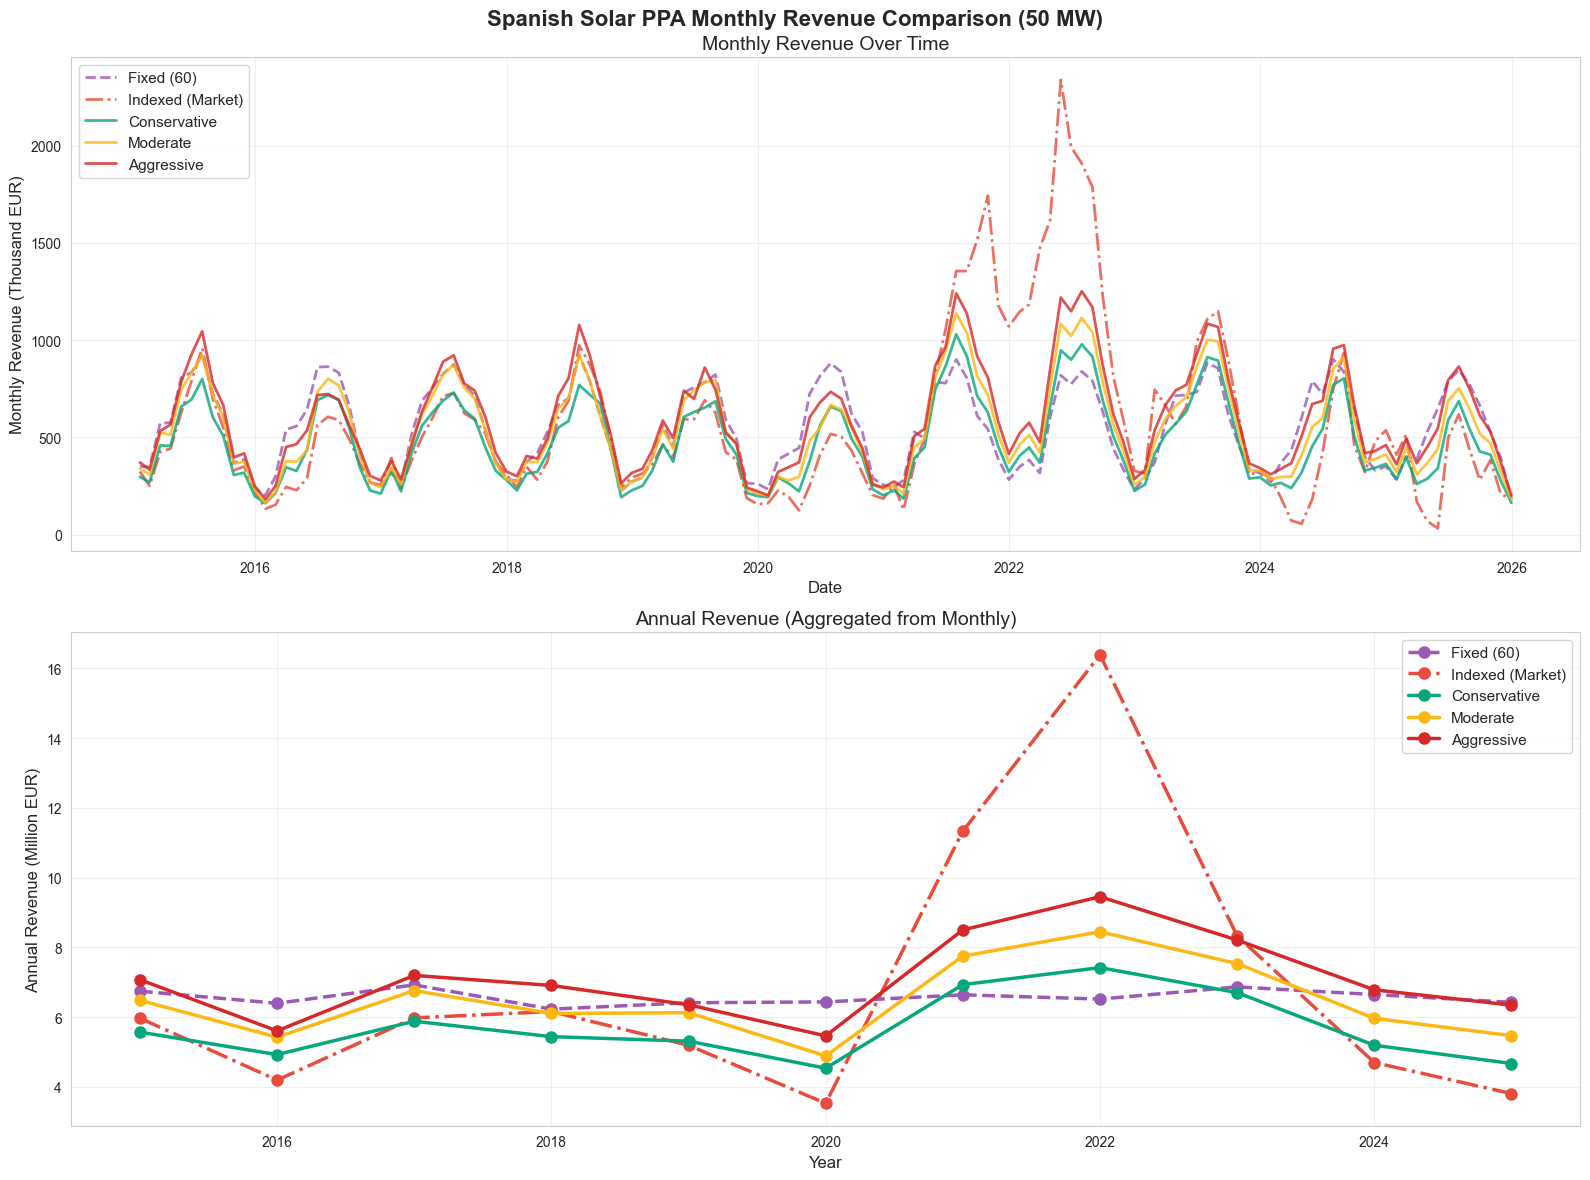


Key observations (Spanish MIBEL market):
- Indexed (Market) shows highest monthly volatility and revenue
- Fixed provides stable monthly baseline (~same every month)
- Collared structures dampen extreme monthly variations
- 2022 shows highest revenues due to European energy crisis
- Monthly view reveals seasonal patterns and risk exposure


In [ ]:
# Create monthly time series plot
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Spanish Solar PPA Monthly Revenue Comparison (50 MW)', fontsize=16 )

# Define colors for each PPA type
colors = {
    'Fixed (60)': '#9B59B6',
    'Indexed (Market)': '#E74C3C',
    'Conservative': '#06A77D',
    'Moderate': '#FDB813',
    'Aggressive': '#D62828'
}

line_styles = {
    'Fixed (60)': '--',
    'Indexed (Market)': '-.',
    'Conservative': '-',
    'Moderate': '-',
    'Aggressive': '-'
}

# Plot 1: Monthly time series
for name, results in solar_results.items():
    monthly_data = results['monthly']
    axes[0].plot(monthly_data.index, monthly_data.values / 1e3, 
                 linewidth=2, label=name, alpha=0.8,
                 color=colors[name], linestyle=line_styles[name])

axes[0].set_title('Monthly Revenue Over Time', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Monthly Revenue (Thousand EUR)', fontsize=12)
axes[0].legend(fontsize=11, loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Annual aggregation for trend
for name, results in solar_results.items():
    annual_data = results['annual']
    axes[1].plot(annual_data.index.year, annual_data.values / 1e6, 
                 marker='o', linewidth=2.5, label=name, markersize=8,
                 color=colors[name], linestyle=line_styles[name])

axes[1].set_title('Annual Revenue (Aggregated from Monthly)', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Annual Revenue (Million EUR)', fontsize=12)
axes[1].legend(fontsize=11, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey observations (Spanish MIBEL market):")
print("- Indexed (Market) shows highest monthly volatility and revenue")
print("- Fixed provides stable monthly baseline (~same every month)")
print("- Collared structures dampen extreme monthly variations")
print("- 2022 shows highest revenues due to European energy crisis")
print("- Monthly view reveals seasonal patterns and risk exposure")


## 7. Total Revenue and Price Volatility Comparison

Compare total revenue and price volatility across all PPA structures.

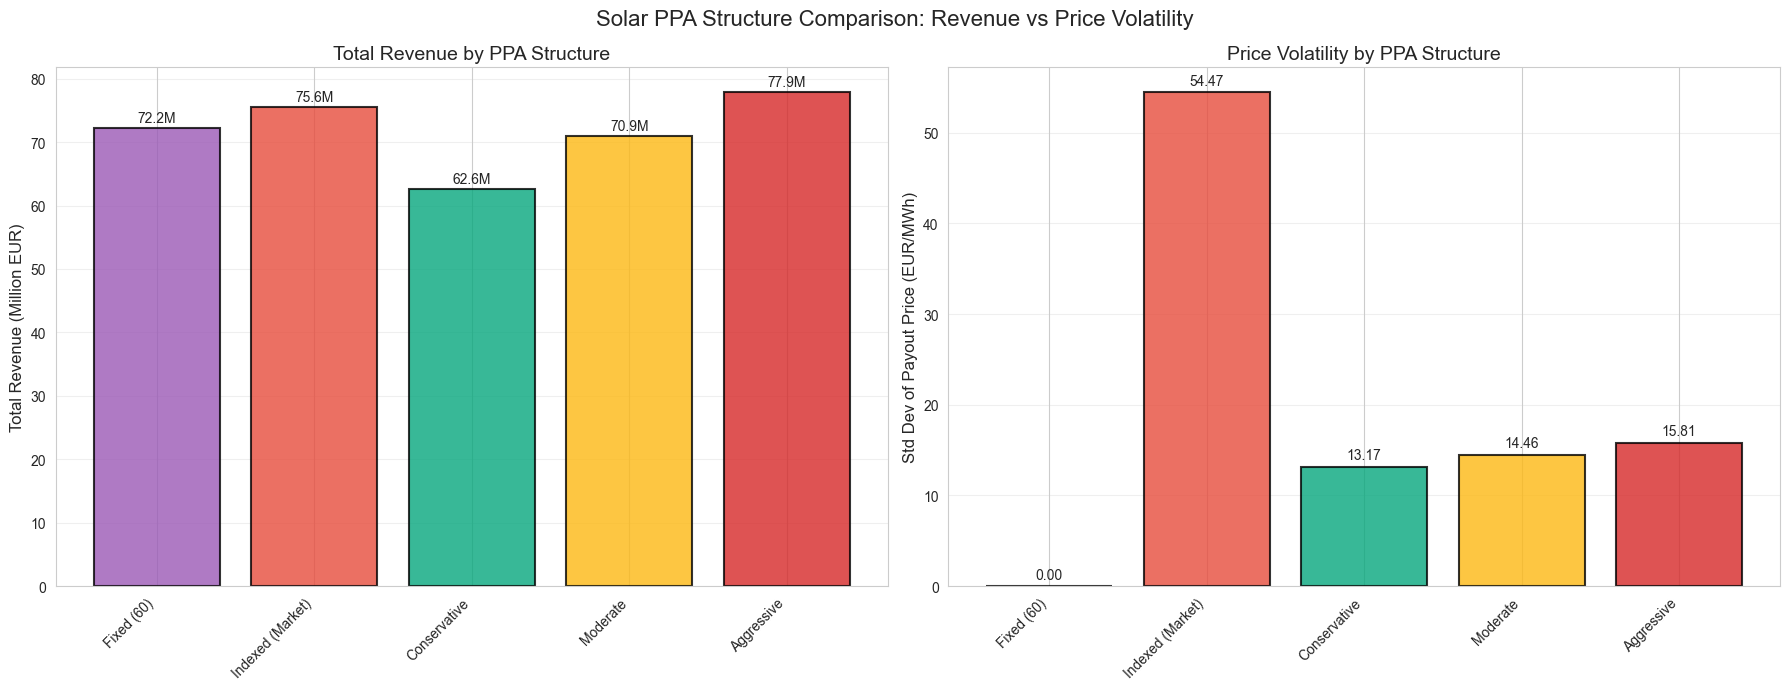


SUMMARY: SOLAR PPA STRUCTURE COMPARISON
PPA Structure               Total Revenue      Mean Price   Std Dev Price
------------------------------------------------------------------------------------------
Fixed (60)                       72.23 M€         60.00 €/MWh          0.00 €/MWh
Indexed (Market)                 75.57 M€         70.46 €/MWh         54.47 €/MWh
Conservative                     62.57 M€         53.59 €/MWh         13.17 €/MWh
Moderate                         70.94 M€         60.46 €/MWh         14.46 €/MWh
Aggressive                       77.88 M€         66.41 €/MWh         15.81 €/MWh

Key Insights:
- Fixed PPA: Zero price volatility, moderate revenue
- Indexed PPA: Highest revenue potential, highest volatility
- Collared PPAs: Balance between revenue and stability


In [10]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Solar PPA Structure Comparison: Revenue vs Price Volatility', fontsize=16 )

# Extract data for plotting
ppa_names = list(solar_results.keys())
total_revenues = [solar_results[name]['stats']['total_revenue'] / 1e6 for name in ppa_names]
price_std_devs = [solar_results[name]['stats']['std_hourly_price'] for name in ppa_names]
mean_prices = [solar_results[name]['stats']['mean_hourly_price'] for name in ppa_names]

plot_colors = [colors[name] for name in ppa_names]

# Plot 1: Total Revenue Comparison
axes[0].bar(range(len(ppa_names)), total_revenues, color=plot_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(ppa_names)))
axes[0].set_xticklabels(ppa_names, rotation=45, ha='right')
axes[0].set_ylabel('Total Revenue (Million EUR)', fontsize=12 )
axes[0].set_title('Total Revenue by PPA Structure', fontsize=14 )
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, val in enumerate(total_revenues):
    axes[0].text(i, val + 0.5, f'{val:.1f}M', ha='center', va='bottom', fontsize=10 )

# Plot 2: Price Volatility (Std Dev) Comparison
axes[1].bar(range(len(ppa_names)), price_std_devs, color=plot_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(ppa_names)))
axes[1].set_xticklabels(ppa_names, rotation=45, ha='right')
axes[1].set_ylabel('Std Dev of Payout Price (EUR/MWh)', fontsize=12 )
axes[1].set_title('Price Volatility by PPA Structure', fontsize=14 )
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, val in enumerate(price_std_devs):
    axes[1].text(i, val + 0.5, f'{val:.2f}', ha='center', va='bottom', fontsize=10 )

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*90)
print("SUMMARY: SOLAR PPA STRUCTURE COMPARISON")
print("="*90)
print(f"{'PPA Structure':<25} {'Total Revenue':>15} {'Mean Price':>15} {'Std Dev Price':>15}")
print("-"*90)
for name in ppa_names:
    print(f"{name:<25} {solar_results[name]['stats']['total_revenue']/1e6:>12,.2f} M€  "
          f"{solar_results[name]['stats']['mean_hourly_price']:>12,.2f} €/MWh  "
          f"{solar_results[name]['stats']['std_hourly_price']:>12,.2f} €/MWh")
print()
print("Key Insights:")
print("- Fixed PPA: Zero price volatility, moderate revenue")
print("- Indexed PPA: Highest revenue potential, highest volatility")
print("- Collared PPAs: Balance between revenue and stability")

## 8. Risk-Return Trade-off Analysis

Visualise the risk-return profile of each PPA structure.

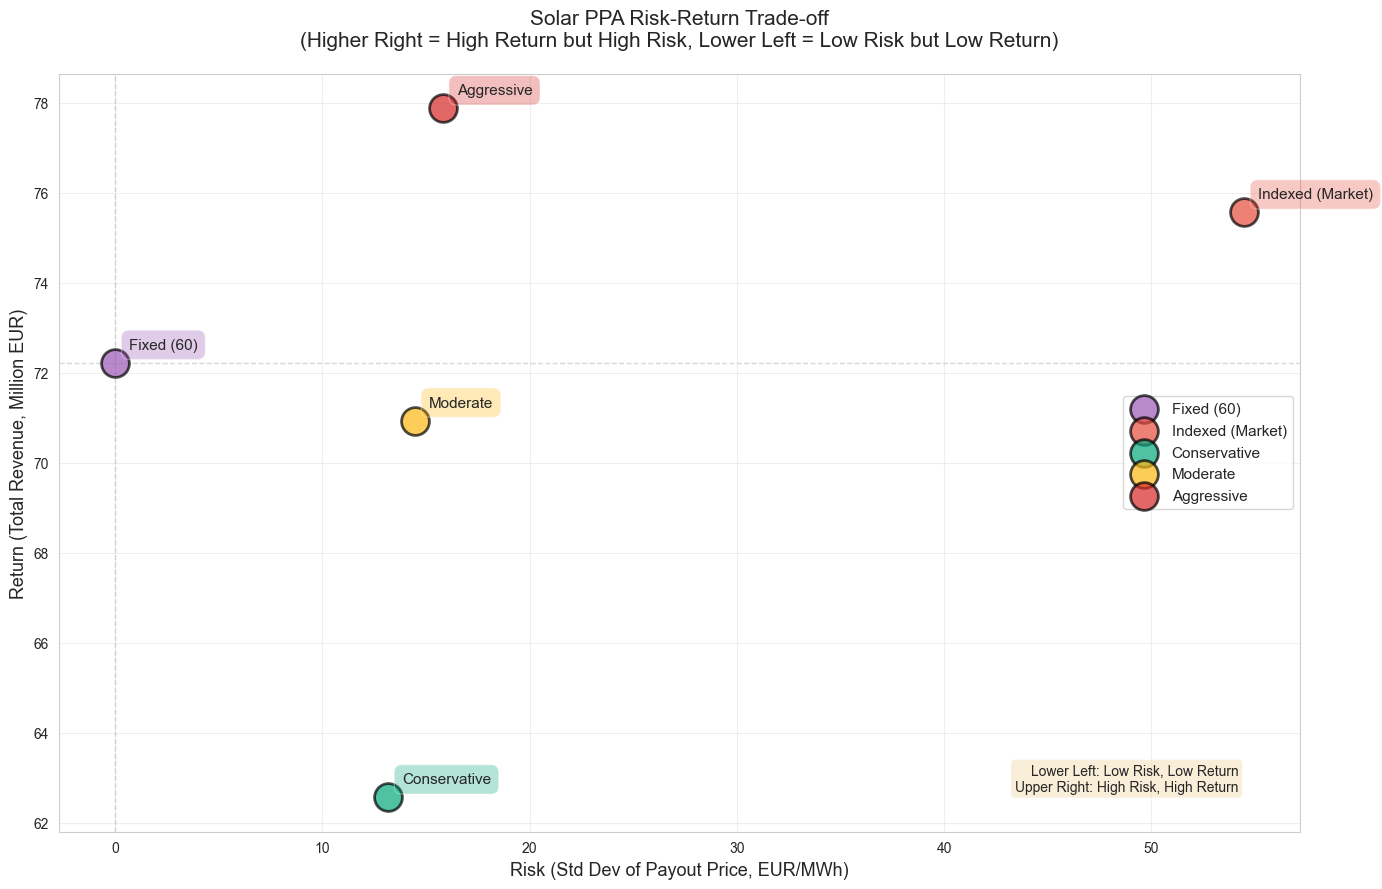


Risk-Return Analysis:
- Fixed PPA: Zero risk (no price volatility), baseline return
- Indexed PPA: Highest risk, highest return
- Collared PPAs: Intermediate positions balancing risk and return
- Conservative collar: Closest to fixed in risk profile
- Aggressive collar: Closer to indexed in risk-return profile


In [11]:
# Create risk-return scatter plot
fig, ax = plt.subplots(figsize=(14, 9))

# Plot each PPA structure
for name in ppa_names:
    revenue = solar_results[name]['stats']['total_revenue'] / 1e6
    risk = solar_results[name]['stats']['std_hourly_price']
    
    ax.scatter(risk, revenue, s=400, alpha=0.7, 
              color=colors[name], edgecolors='black', linewidth=2,
              label=name, zorder=3)
    
    # Add labels
    ax.annotate(name, (risk, revenue), 
               xytext=(10, 10), textcoords='offset points',
               fontsize=11,
               bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[name], alpha=0.3))

ax.set_xlabel('Risk (Std Dev of Payout Price, EUR/MWh)', fontsize=13)
ax.set_ylabel('Return (Total Revenue, Million EUR)', fontsize=13)
ax.set_title('Solar PPA Risk-Return Trade-off\n(Higher Right = High Return but High Risk, Lower Left = Low Risk but Low Return)', 
            fontsize=15, pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='best')

# Add quadrant labels
ax.axhline(y=total_revenues[0], color='gray', linestyle='--', alpha=0.3, linewidth=1)  # Fixed revenue as baseline
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=1)

# Annotate efficient frontier concept
ax.text(0.95, 0.05, 'Lower Left: Low Risk, Low Return\nUpper Right: High Risk, High Return', 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right',

        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nRisk-Return Analysis:")
print("- Fixed PPA: Zero risk (no price volatility), baseline return")
print("- Indexed PPA: Highest risk, highest return")
print("- Collared PPAs: Intermediate positions balancing risk and return")
print("- Conservative collar: Closest to fixed in risk profile")
print("- Aggressive collar: Closer to indexed in risk-return profile")

## 9. Regime Frequency Analysis (Collared PPAs)

Visualise how often each regime (floor/strike/cap) is active under different collared PPA structures.

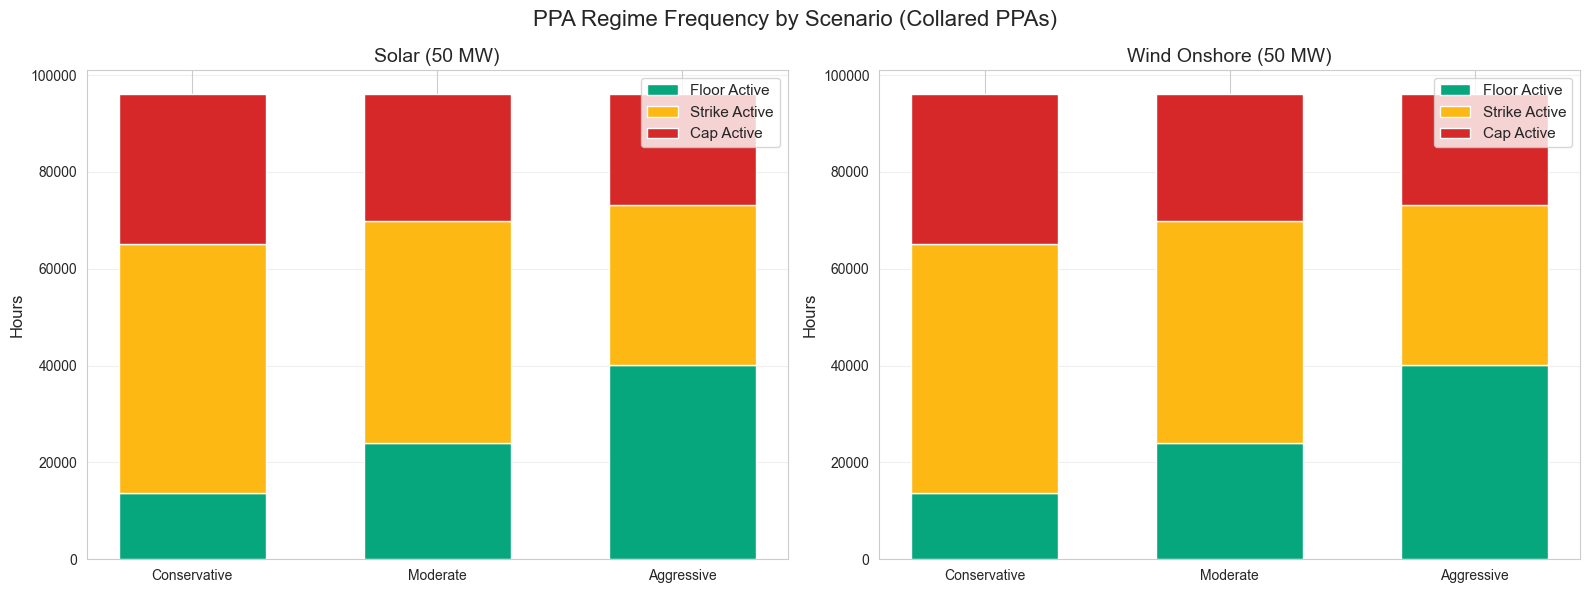

In [12]:
# Prepare data for stacked bar chart (Collared PPAs only)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('PPA Regime Frequency by Scenario (Collared PPAs)', fontsize=16)

# Filter to only include Collared PPAs
collared_names = [name for name in solar_results.keys() if solar_results[name]['ppa_type'] == 'Collared']

# Solar regime frequencies
floor_hours_solar = [solar_results[s]['stats']['hours_floor_active'] for s in collared_names]
strike_hours_solar = [solar_results[s]['stats']['hours_strike_active'] for s in collared_names]
cap_hours_solar = [solar_results[s]['stats']['hours_cap_active'] for s in collared_names]

x = np.arange(len(collared_names))
width = 0.6

axes[0].bar(x, floor_hours_solar, width, label='Floor Active', color='#06A77D')
axes[0].bar(x, strike_hours_solar, width, bottom=floor_hours_solar, 
           label='Strike Active', color='#FDB813')
axes[0].bar(x, cap_hours_solar, width, 
           bottom=np.array(floor_hours_solar) + np.array(strike_hours_solar),
           label='Cap Active', color='#D62828')

axes[0].set_title('Solar (50 MW)', fontsize=14)
axes[0].set_ylabel('Hours', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(collared_names)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Wind regime frequencies
floor_hours_wind = [wind_results[s]['stats']['hours_floor_active'] for s in collared_names]
strike_hours_wind = [wind_results[s]['stats']['hours_strike_active'] for s in collared_names]
cap_hours_wind = [wind_results[s]['stats']['hours_cap_active'] for s in collared_names]

axes[1].bar(x, floor_hours_wind, width, label='Floor Active', color='#06A77D')
axes[1].bar(x, strike_hours_wind, width, bottom=floor_hours_wind, 
           label='Strike Active', color='#FDB813')
axes[1].bar(x, cap_hours_wind, width, 
           bottom=np.array(floor_hours_wind) + np.array(strike_hours_wind),
           label='Cap Active', color='#D62828')

axes[1].set_title('Wind Onshore (50 MW)', fontsize=14)
axes[1].set_ylabel('Hours', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(collared_names)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. PPA Revenue vs Market Revenue (Opportunity Cost)

Compare PPA revenue to what the seller would have earned by selling at market prices.
Analysis at both monthly and annual levels to align with CVaR optimisation.


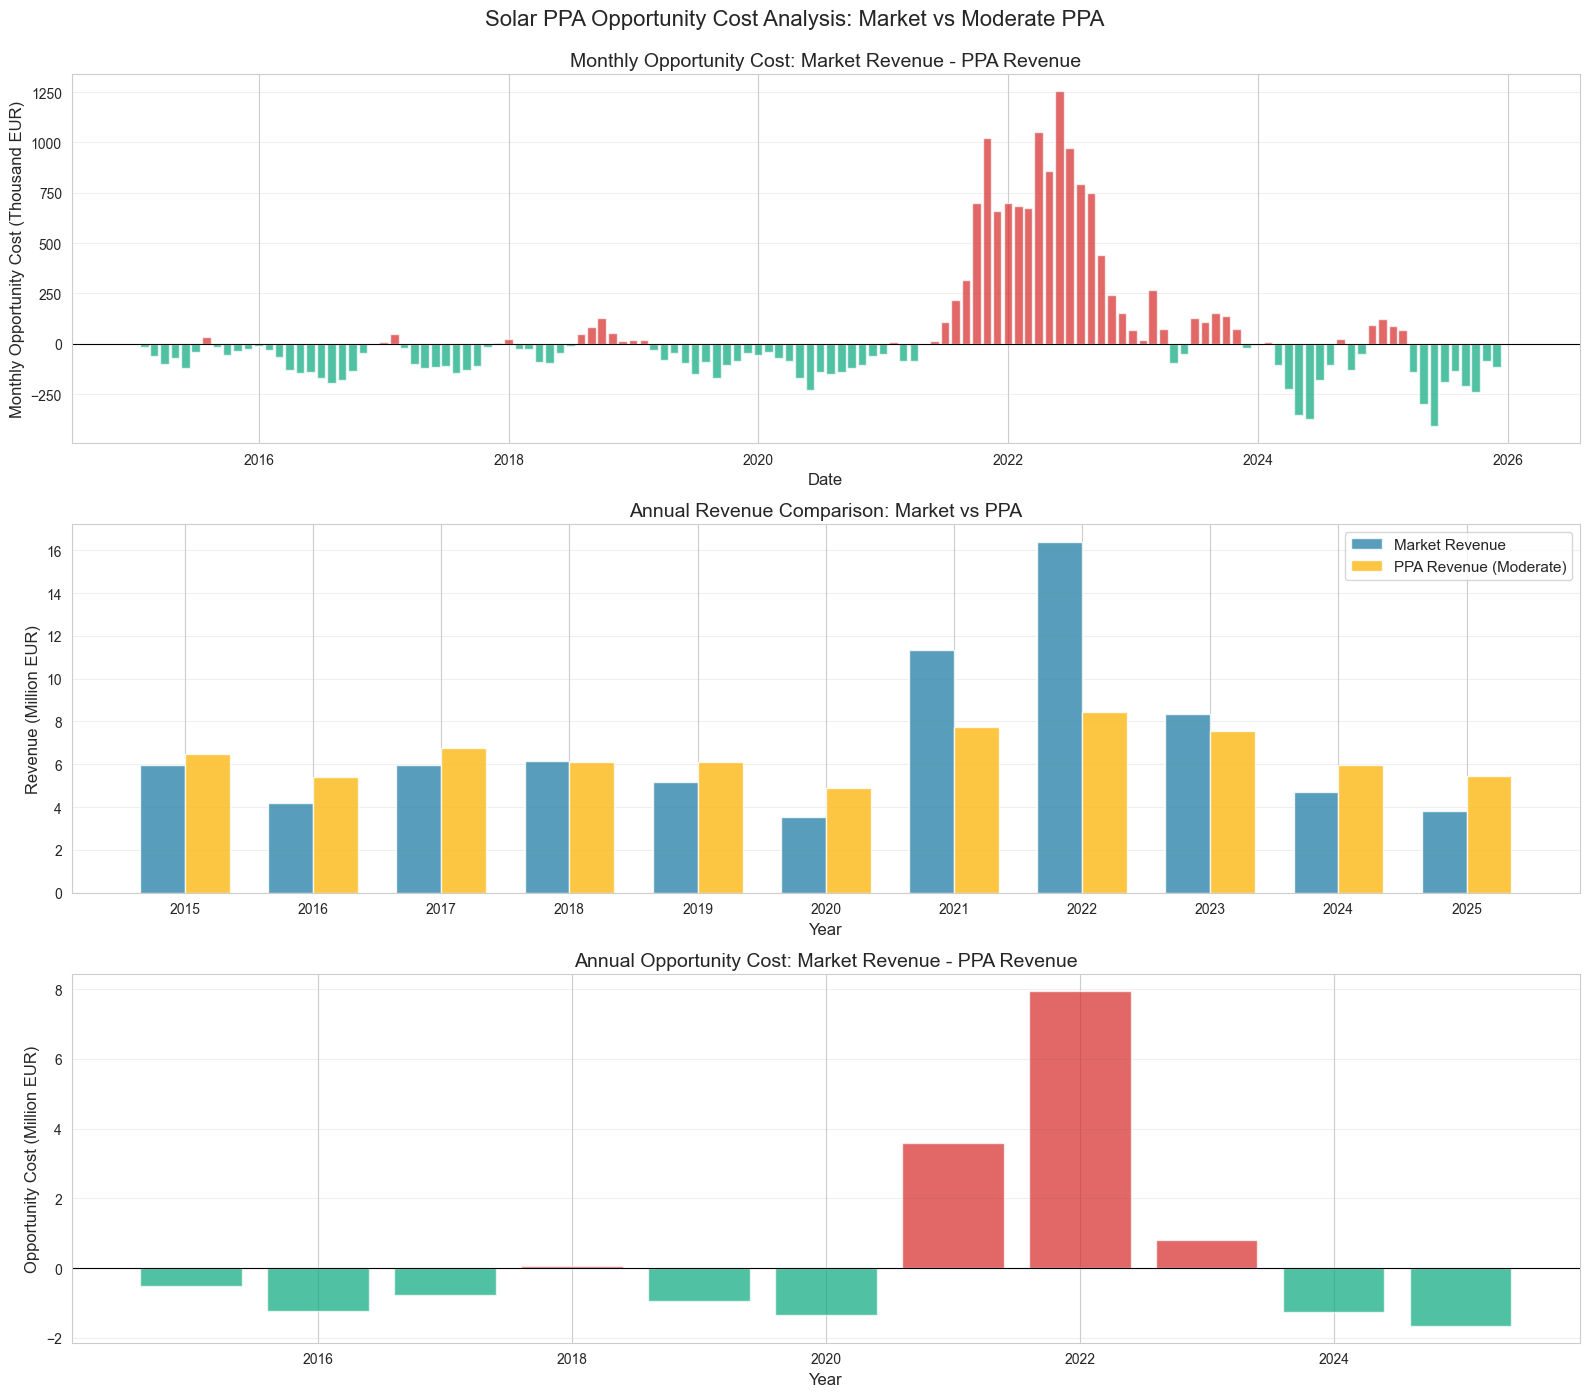


OPPORTUNITY COST ANALYSIS - SOLAR (Moderate Scenario)

ANNUAL TOTALS:
Total Market Revenue:           75.57 Million EUR
Total PPA Revenue:              70.94 Million EUR
Total Opportunity Cost:          4.62 Million EUR
PPA as % of Market:              93.9%

MONTHLY AVERAGES:
Mean Monthly Market Rev:       572.47 Thousand EUR
Mean Monthly PPA Rev:          537.44 Thousand EUR
Mean Monthly Opp Cost:          35.03 Thousand EUR
Std Dev Monthly Opp Cost:      288.86 Thousand EUR

MONTHLY INSIGHTS:
Months with positive cost (cap limiting upside):  49 (37.1%)
Months with negative cost (floor protection):     83 (62.9%)

INTERPRETATION:
- Positive opportunity cost: Seller gave up revenue (cap limiting upside)
- Negative opportunity cost: Seller gained revenue (floor protection)
- 2022 shows largest opportunity cost due to extreme high prices
- Monthly view reveals when PPA protection vs. limitation matters most


In [16]:
# Calculate market revenue at both monthly and annual levels
market_revenue_solar_annual = (prices_solar * generation_solar).resample('YE').sum()
market_revenue_solar_monthly = (prices_solar * generation_solar).resample('ME').sum()

# Calculate PPA revenues for moderate scenario at both levels
moderate_params = scenarios['Moderate']
ppa_revenue_solar_annual = ppa_payoff_aggregate(
    ppa_payoff(prices_solar, generation_solar, *moderate_params),
    freq='YE'
)
ppa_revenue_solar_monthly = ppa_payoff_aggregate(
    ppa_payoff(prices_solar, generation_solar, *moderate_params),
    freq='ME'
)

# Calculate opportunity cost at both levels
opportunity_cost_annual = market_revenue_solar_annual - ppa_revenue_solar_annual
opportunity_cost_monthly = market_revenue_solar_monthly - ppa_revenue_solar_monthly

# Create comparison plot with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Solar PPA Opportunity Cost Analysis: Market vs Moderate PPA', fontsize=16, y=0.995)

# Plot 1: Monthly opportunity cost time series
colors_monthly = ['#D62828' if val > 0 else '#06A77D' for val in opportunity_cost_monthly.values]
axes[0].bar(opportunity_cost_monthly.index, opportunity_cost_monthly.values / 1e3, 
           color=colors_monthly, alpha=0.7, width=25)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Monthly Opportunity Cost (Thousand EUR)', fontsize=12)
axes[0].set_title('Monthly Opportunity Cost: Market Revenue - PPA Revenue', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Annual revenue comparison
years = market_revenue_solar_annual.index.year
x = np.arange(len(years))
width = 0.35

axes[1].bar(x - width/2, market_revenue_solar_annual.values / 1e6, width, 
           label='Market Revenue', color='#2E86AB', alpha=0.8)
axes[1].bar(x + width/2, ppa_revenue_solar_annual.values / 1e6, width, 
           label='PPA Revenue (Moderate)', color='#FDB813', alpha=0.8)

axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Revenue (Million EUR)', fontsize=12)
axes[1].set_title('Annual Revenue Comparison: Market vs PPA', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(years)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Annual opportunity cost
colors_annual = ['#D62828' if val > 0 else '#06A77D' for val in opportunity_cost_annual.values]
axes[2].bar(years, opportunity_cost_annual.values / 1e6, color=colors_annual, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('Opportunity Cost (Million EUR)', fontsize=12)
axes[2].set_title('Annual Opportunity Cost: Market Revenue - PPA Revenue', fontsize=14)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
total_market = market_revenue_solar_annual.sum()
total_ppa = ppa_revenue_solar_annual.sum()
total_cost = opportunity_cost_annual.sum()

# Monthly statistics
mean_monthly_market = market_revenue_solar_monthly.mean()
mean_monthly_ppa = ppa_revenue_solar_monthly.mean()
mean_monthly_cost = opportunity_cost_monthly.mean()
std_monthly_cost = opportunity_cost_monthly.std()

print("\n" + "="*80)
print("OPPORTUNITY COST ANALYSIS - SOLAR (Moderate Scenario)")
print("="*80)
print("\nANNUAL TOTALS:")
print(f"Total Market Revenue:      {total_market/1e6:>10,.2f} Million EUR")
print(f"Total PPA Revenue:         {total_ppa/1e6:>10,.2f} Million EUR")
print(f"Total Opportunity Cost:    {total_cost/1e6:>10,.2f} Million EUR")
print(f"PPA as % of Market:        {total_ppa/total_market*100:>10,.1f}%")

print("\nMONTHLY AVERAGES:")
print(f"Mean Monthly Market Rev:   {mean_monthly_market/1e3:>10,.2f} Thousand EUR")
print(f"Mean Monthly PPA Rev:      {mean_monthly_ppa/1e3:>10,.2f} Thousand EUR")
print(f"Mean Monthly Opp Cost:     {mean_monthly_cost/1e3:>10,.2f} Thousand EUR")
print(f"Std Dev Monthly Opp Cost:  {std_monthly_cost/1e3:>10,.2f} Thousand EUR")

print("\nMONTHLY INSIGHTS:")
positive_months = (opportunity_cost_monthly > 0).sum()
negative_months = (opportunity_cost_monthly < 0).sum()
print(f"Months with positive cost (cap limiting upside):  {positive_months} ({positive_months/len(opportunity_cost_monthly)*100:.1f}%)")
print(f"Months with negative cost (floor protection):     {negative_months} ({negative_months/len(opportunity_cost_monthly)*100:.1f}%)")

print("\nINTERPRETATION:")
print("- Positive opportunity cost: Seller gave up revenue (cap limiting upside)")
print("- Negative opportunity cost: Seller gained revenue (floor protection)")
print("- 2022 shows largest opportunity cost due to extreme high prices")
print("- Monthly view reveals when PPA protection vs. limitation matters most")


## 11. Revenue Volatility Analysis

Compare revenue volatility under PPA vs market settlement.

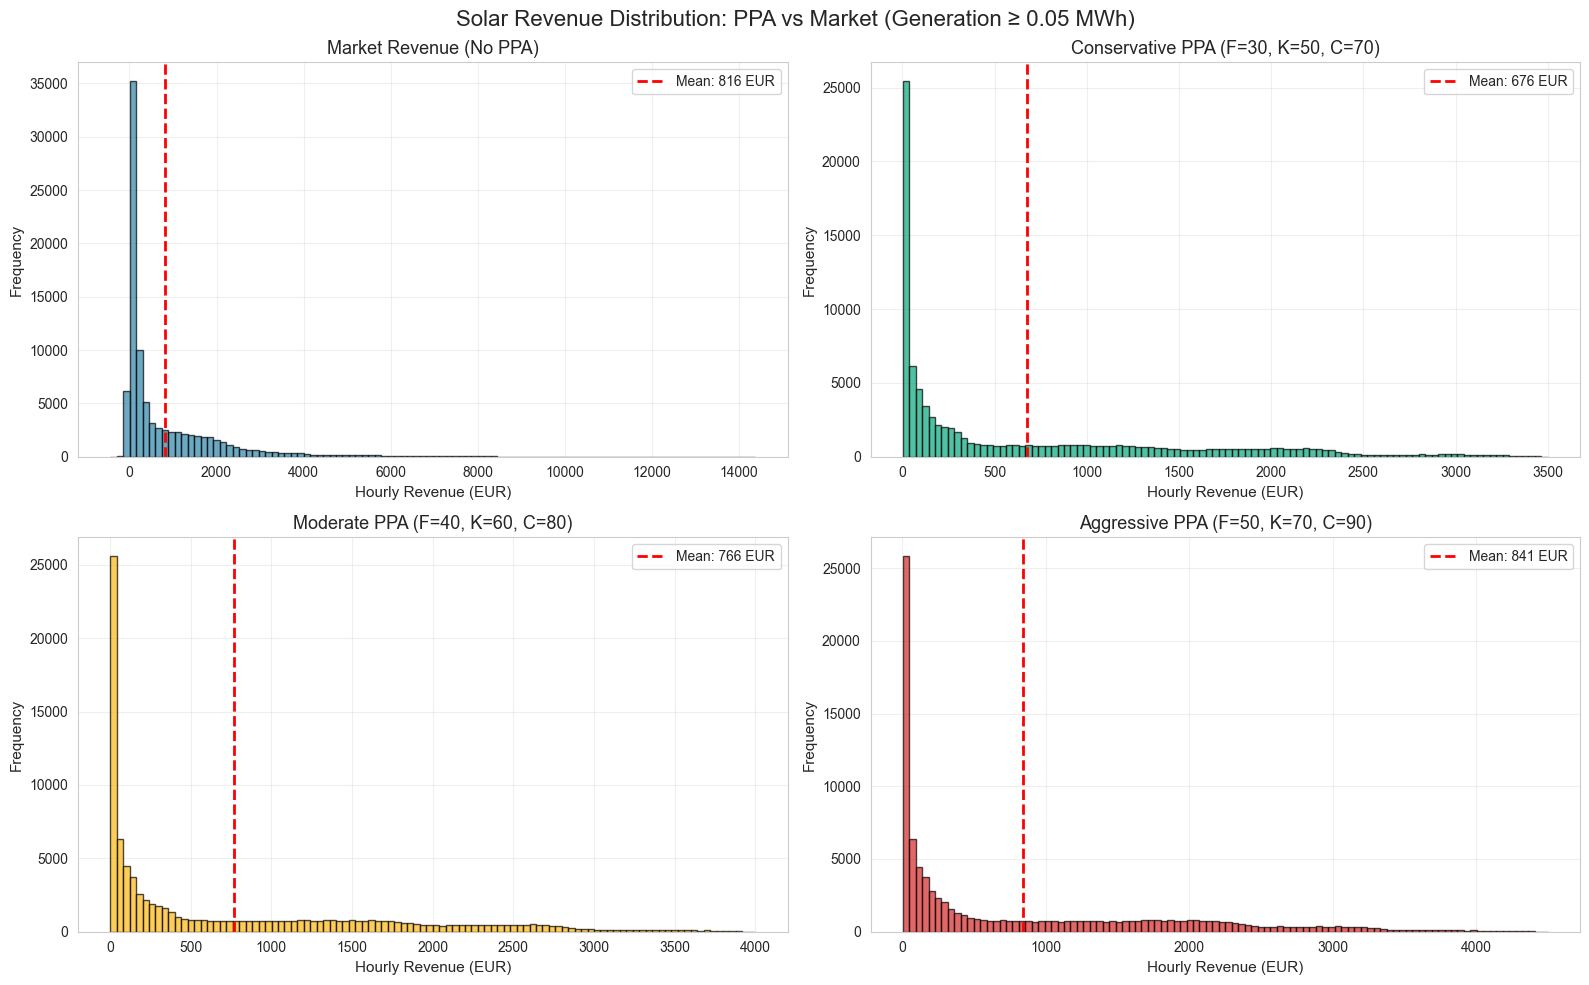


REVENUE VOLATILITY COMPARISON - SOLAR (Generation ≥ 0.05 MWh)
Hours included: 92,615 out of 96,170 total hours (96.3%)

Market (No PPA):        Std Dev =   1,289.02 EUR  |  CoV = 1.580
Conservative PPA:       Std Dev =     825.78 EUR  |  CoV = 1.222
Moderate PPA:           Std Dev =     929.32 EUR  |  CoV = 1.213
Aggressive PPA:         Std Dev =   1,014.92 EUR  |  CoV = 1.207

Note: CoV = Coefficient of Variation (Std Dev / Mean)
Lower CoV indicates more stable revenue stream


In [14]:
# Filter out low generation hours (< 0.05 MWh)
generation_mask = generation_solar >= 0.05
prices_solar_filtered = prices_solar[generation_mask]
generation_solar_filtered = generation_solar[generation_mask]

# Calculate hourly revenues
market_hourly = prices_solar_filtered * generation_solar_filtered
ppa_hourly_conservative = ppa_payoff(prices_solar_filtered, generation_solar_filtered, *scenarios['Conservative'])
ppa_hourly_moderate = ppa_payoff(prices_solar_filtered, generation_solar_filtered, *scenarios['Moderate'])
ppa_hourly_aggressive = ppa_payoff(prices_solar_filtered, generation_solar_filtered, *scenarios['Aggressive'])

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Solar Revenue Distribution: PPA vs Market (Generation ≥ 0.05 MWh)', fontsize=16)

# Market
axes[0, 0].hist(market_hourly, bins=100, alpha=0.7, color='#2E86AB', edgecolor='black')
axes[0, 0].axvline(market_hourly.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {market_hourly.mean():.0f} EUR')
axes[0, 0].set_title('Market Revenue (No PPA)', fontsize=13)
axes[0, 0].set_xlabel('Hourly Revenue (EUR)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Conservative PPA
axes[0, 1].hist(ppa_hourly_conservative, bins=100, alpha=0.7, color='#06A77D', edgecolor='black')
axes[0, 1].axvline(ppa_hourly_conservative.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ppa_hourly_conservative.mean():.0f} EUR')
axes[0, 1].set_title('Conservative PPA (F=30, K=50, C=70)', fontsize=13)
axes[0, 1].set_xlabel('Hourly Revenue (EUR)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Moderate PPA
axes[1, 0].hist(ppa_hourly_moderate, bins=100, alpha=0.7, color='#FDB813', edgecolor='black')
axes[1, 0].axvline(ppa_hourly_moderate.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ppa_hourly_moderate.mean():.0f} EUR')
axes[1, 0].set_title('Moderate PPA (F=40, K=60, C=80)', fontsize=13)
axes[1, 0].set_xlabel('Hourly Revenue (EUR)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Aggressive PPA
axes[1, 1].hist(ppa_hourly_aggressive, bins=100, alpha=0.7, color='#D62828', edgecolor='black')
axes[1, 1].axvline(ppa_hourly_aggressive.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ppa_hourly_aggressive.mean():.0f} EUR')
axes[1, 1].set_title('Aggressive PPA (F=50, K=70, C=90)', fontsize=13)
axes[1, 1].set_xlabel('Hourly Revenue (EUR)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Volatility comparison
print("\n" + "="*80)
print("REVENUE VOLATILITY COMPARISON - SOLAR (Generation ≥ 0.05 MWh)")
print("="*80)
print(f"Hours included: {len(market_hourly):,} out of {len(prices_solar):,} total hours ({len(market_hourly)/len(prices_solar)*100:.1f}%)")
print(f"\nMarket (No PPA):        Std Dev = {market_hourly.std():>10,.2f} EUR  |  CoV = {market_hourly.std()/market_hourly.mean():.3f}")
print(f"Conservative PPA:       Std Dev = {ppa_hourly_conservative.std():>10,.2f} EUR  |  CoV = {ppa_hourly_conservative.std()/ppa_hourly_conservative.mean():.3f}")
print(f"Moderate PPA:           Std Dev = {ppa_hourly_moderate.std():>10,.2f} EUR  |  CoV = {ppa_hourly_moderate.std()/ppa_hourly_moderate.mean():.3f}")
print(f"Aggressive PPA:         Std Dev = {ppa_hourly_aggressive.std():>10,.2f} EUR  |  CoV = {ppa_hourly_aggressive.std()/ppa_hourly_aggressive.mean():.3f}")
print("\nNote: CoV = Coefficient of Variation (Std Dev / Mean)")
print("Lower CoV indicates more stable revenue stream")

## 12. Key Insights & Next Steps

### PPA Structure Impact
1. **Higher floor/strike/cap**: Higher total revenue but less downside protection relative to strike
2. **Floor provides downside protection**: Activates 16-29% of hours depending on level
3. **Cap limits upside**: Activates 46-60% of hours, constraining high-price benefits

### Revenue Stability
- PPA structures reduce revenue volatility compared to market settlement
- Conservative structures have lowest volatility but also lowest total revenue
- Trade-off between revenue maximisation and stability

### Opportunity Cost
- 2022 shows largest opportunity cost due to extreme high prices
- Floor protection valuable in low-price years
- Cap cost significant in high-price environments

### Optimisation Considerations
- Need to define objective: Maximise revenue? Minimise risk? Balance both?
- Risk metrics (VaR, CVaR) needed for risk-averse optimisation
- Sharpe-like ratio could balance risk-return trade-off

### Next Steps
1. Define objective function(s) for optimisation
2. Implement risk metrics (VaR, CVaR)
3. Formulate optimisation problem with constraints
4. Implement heuristic algorithms